# Conditional DCGAN on CIFAR-10, MNIST, and FMNIST datasets

*Implementation of conditional DCGAN on MNIST, FMNIST, and CIFAR-10 dataset.* Adapted from *Conditional DCGAN*, by  Q. Garrido, 2020 (https://github.com/garridoq/gan-guide/blob/master/Conditional%20DCGAN.ipynb)

DCGANs were first introduced in https://arxiv.org/abs/1511.06434 

Conditional GAN were first introduced in https://arxiv.org/abs/1411.1784 

In [1]:
# Enable for Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/

# Imports, and helper functions

Import libraries

In [2]:
# Coding
import tensorflow as tf 
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds
import numpy as np

# Plotting and manipulating images
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import imageio
import glob
import PIL
from IPython import display

# Timing
import datetime
import time

# Managing folders 
import os
import shutil

Create folders

In [21]:
# Remove old folders created during training

DATASET = "MNIST" # "MNIST", "FMNIST" or "CIFAR10

rm_path = "." + os.sep + DATASET + os.sep + "imgs"
if os.path.exists(rm_path):
    shutil.rmtree(rm_path)

# Create folders to save images, models and checkpoints
newpaths = ["." + os.sep + DATASET + os.sep + "imgs", 
            "." + os.sep + DATASET + os.sep + "models",
            "." + os.sep + DATASET + os.sep + "losses"]
for newpath in newpaths:
    if not os.path.exists(newpath):
        os.makedirs(newpath)

Helper functions

In [9]:
def generate_and_save_images(model,
                             epoch,
                             test_input,
                             g_loss,
                             d_loss,
                             conditions=None,
                             x_axis="scale",
                             y_max=5,
                             save=True):

  # Set `training` to False so all layers run in inference mode.
    if conditions is not None:
        predictions = model([test_input, conditions], training=False)
    else:
        predictions = model([test_input], training=False)

    fig = plt.figure(figsize=(20,8))
    outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

    inner_im = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=outer[0], wspace=0.1, hspace=0.1)

    for i in range(predictions.shape[0]):
        ax = plt.Subplot(fig, inner_im[i])
        ax.imshow((predictions[i]+1) / 2 )
        if conditions is not None:
            ax.title.set_text(CLASSES[conditions[i][0]])
        ax.axis('off')
        fig.add_subplot(ax)
    
    if save:
        fig.savefig("." + os.sep + DATASET + os.sep + 'imgs' + os.sep + 'image_at_epoch_{:04d}.png'.format(epoch), bbox_inches="tight")
        model.save("." + os.sep + DATASET + os.sep + 'models' + os.sep + 'generator_at_epoch_{:04d}.h5'.format(epoch))
    
    inner_l = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[1], wspace=0.1, hspace=0.1)
    
    ax1 = plt.Subplot(fig, inner_l[0])
    
    samples = 1000
    g_losses_sampled = []
    d_losses_sampled = []
    xs = []

    for i in range(len(g_loss) // samples):
        g_losses_sampled.append(np.mean(g_loss[i*samples:(i+1)*samples]))
        d_losses_sampled.append(np.mean(d_loss[i*samples:(i+1)*samples]))
        xs.append(i*samples + samples/2)

    ax1.plot(xs, g_losses_sampled, "r-")
    ax1.plot(xs, d_losses_sampled, "b-")

    red_patch = mpatches.Patch(color='red', label='Generator loss')
    blue_patch = mpatches.Patch(color='blue', label='Discriminator loss')
    ax1.legend(handles=[red_patch,blue_patch])
    
    if x_axis == "total":
        ax1.set_xlim([0, TOTAL_IMAGES//BATCH_SIZE * EPOCHS])
    else:
        ax1.set_xlim([0, xs[-1] + xs[-1]*0.1])
    ax1.set_ylim([0, y_max])
    
    fig.add_subplot(ax1)
    
    plt.show()

# Hyperparameters

In [10]:
# Training parameters
EPOCHS =         1000
BATCH_SIZE =     128      # Amount of images processed before backpropagating

# Models parameters
LATENT_DIM =     100      # Amount of features for the generator
KERNEL_SIZE =    (5, 5)   # Kernel size for the convolutional layers
MOMENTUM =       0.9      # Momentum for the batch normalization layers
DROPOUT =        0.4      # Dropout rate
ALPHA =          0.2      # Alpha for the leaky ReLU slope

# Optimizer parameters
LEARNING_RATE =  2e-4     # Learning rate for the Adam Optimizer
BETA_1 =         0.5      # Beta_1 for the Adam Optimizer
BETA_2 =         0.9      # Beta_2 for the Adam Optimizer

# Display parameters
NUM_EXAMPLES =   20       # Amount of examples to generate

# Data loading and preprocessing

Load and preprocess the dataset.

In [11]:
def preprocess_image(image,label):
    image = tf.cast(image, tf.float32)/127.5 - 1
    return image, label

In [12]:
# Load dataset
(train, test), info = tfds.load(
    "fashion_mnist" if DATASET == "FMNIST" else DATASET.lower(),
    split=["train", "test"],
    as_supervised=True,
    with_info=True,
    shuffle_files=True,
)

# extract metadata from dataset
CLASSES = info.features["label"].names
NUM_CLASSES = info.features["label"].num_classes
IMAGE_SIZE, _, IMAGE_CHANNELS = info.features["image"].shape
TOTAL_IMAGES = len(train) + len(test)

# preprocess dataset
dataset = (
    train.concatenate(test) # use all data for training
    .map(lambda x,y: preprocess_image(x,y))
    .shuffle(TOTAL_IMAGES)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

# Network Architecture

In this section, we will detail what architectures are used for training the conditional DCGAN.

**For our generator, we will use the following architecture :**

In [13]:
def upsample(x, nfilters, bn=False, drpout=False):
    x = Conv2DTranspose(nfilters, kernel_size=KERNEL_SIZE, strides=2, padding="same", use_bias=False)(x)
    if bn:
        x = BatchNormalization(momentum=MOMENTUM)(x)
    x = LeakyReLU(alpha=ALPHA)(x)
    if drpout:
        x = Dropout(DROPOUT)(x)
    return x

def merge_noise_label(noise, label, init_size = 4, nfilters = 256):
    # Embedding layer for the labels
    lbls = Embedding(10, LATENT_DIM)(label)
    lbls = Dense(init_size * init_size)(lbls)
    lbls = Reshape((init_size, init_size, 1))(lbls)

    # Image from noise
    hid = Dense(init_size * init_size * nfilters, use_bias=False)(noise)
    hid = BatchNormalization(momentum=MOMENTUM)(hid)
    hid = LeakyReLU(alpha=ALPHA)(hid)
    hid = Reshape((init_size,init_size,nfilters))(hid) 
    return Concatenate()([hid, lbls])

def build_generator(verbose=False):

    noise = Input(shape=(LATENT_DIM,))
    label = Input(shape=(1,))

    if DATASET == "CIFAR10":
        merged = merge_noise_label(noise, label)
        hid = upsample(merged, 256, bn=True)
        hid = upsample(hid, 128, bn=True)
        hid = upsample(hid, 64, bn=True)
    elif DATASET == "FMNIST" or DATASET == "MNIST":
        merged = merge_noise_label(noise, label, init_size=7, nfilters=128)
        hid = upsample(merged, 128, bn=True)
        hid = upsample(hid, 128, bn=True)
    else:
        raise Exception("Dataset not supported")

    hid = Conv2D(IMAGE_CHANNELS, kernel_size=KERNEL_SIZE, padding="same")(hid)
    out = Activation("tanh")(hid)

    model = tf.keras.Model(inputs=[noise, label], outputs=out)
    
    if verbose:
        model.summary()
    
    return model

**For our discriminator, we will use the following architecture :**

In [14]:
def downsample(x, nfilters, bn=False):
    x = Conv2D(nfilters, kernel_size=KERNEL_SIZE, strides=2, padding="same", use_bias=False)(x)
    if bn:
        x = BatchNormalization(momentum=MOMENTUM)(x)
    x = LeakyReLU(alpha=ALPHA)(x)
    return x

def build_discriminator(verbose=False):

    image = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS))
    label = Input(shape=(1,))

    # Create embedding layer for label
    lbl = Embedding(10, LATENT_DIM)(label)
    lbl = Dense(IMAGE_SIZE * IMAGE_SIZE)(lbl)
    lbl = Reshape((IMAGE_SIZE, IMAGE_SIZE, 1))(lbl)

    # Combine image and label
    hid = Concatenate()([image, lbl])

    if DATASET == "CIFAR10":
        hid = downsample(hid, 64)
        hid = downsample(hid, 128, bn=True)
        hid = downsample(hid, 256, bn=True)
    elif DATASET == "FMNIST" or DATASET == "MNIST":
        hid = downsample(hid, 128)
        hid = downsample(hid, 128, bn=True)
    else:
        raise Exception("Dataset not supported")

    hid = Flatten()(hid)
    hid = Dropout(DROPOUT)(hid)
    out = Dense(1)(hid) # No sigmoid activation because we use Cross Entropy with from_logits=True
    
    model = tf.keras.Model(inputs=[image, label], outputs=out)
    
    if verbose:
        model.summary()
    
    return model

Loading the generator

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 4096)         409600      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 4096)        16384       ['dense_1[0][0]']                
 alization)                                                                                   

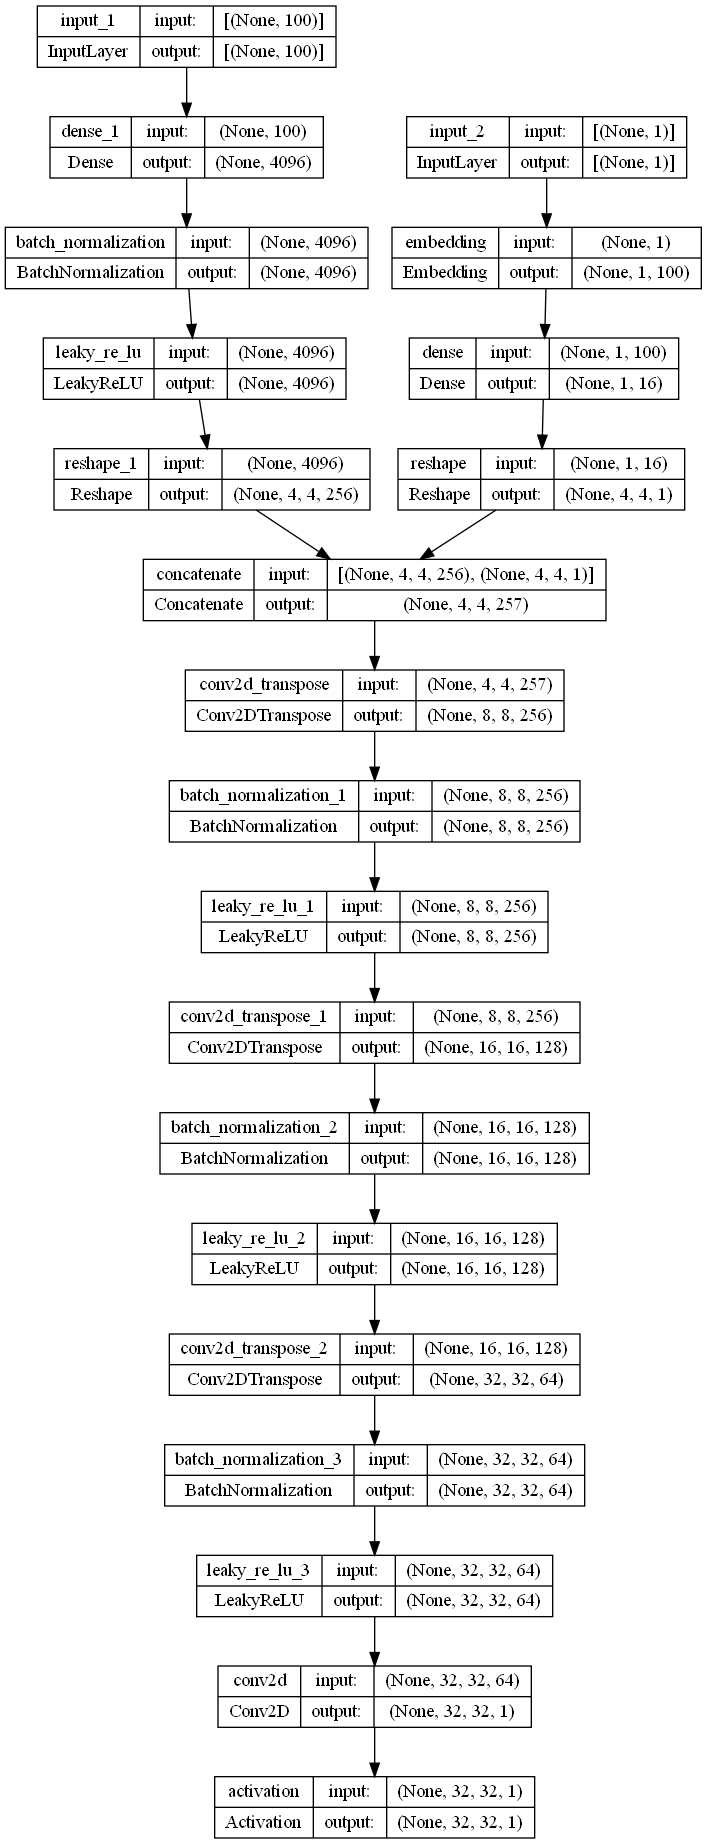

In [22]:
MODEL_PATH = "." + os.sep + DATASET + os.sep

# Clear previous models from memory
tf.keras.backend.clear_session()

# Build generator
generator = build_generator(verbose=True)

# Describe model
plot_model(generator, show_shapes=True, show_layer_names=True, to_file = MODEL_PATH + "generator.png")

Loading the discriminator

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       1000        ['input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 784)       79184       ['embedding[0][0]']              
                                                                                                  
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                              

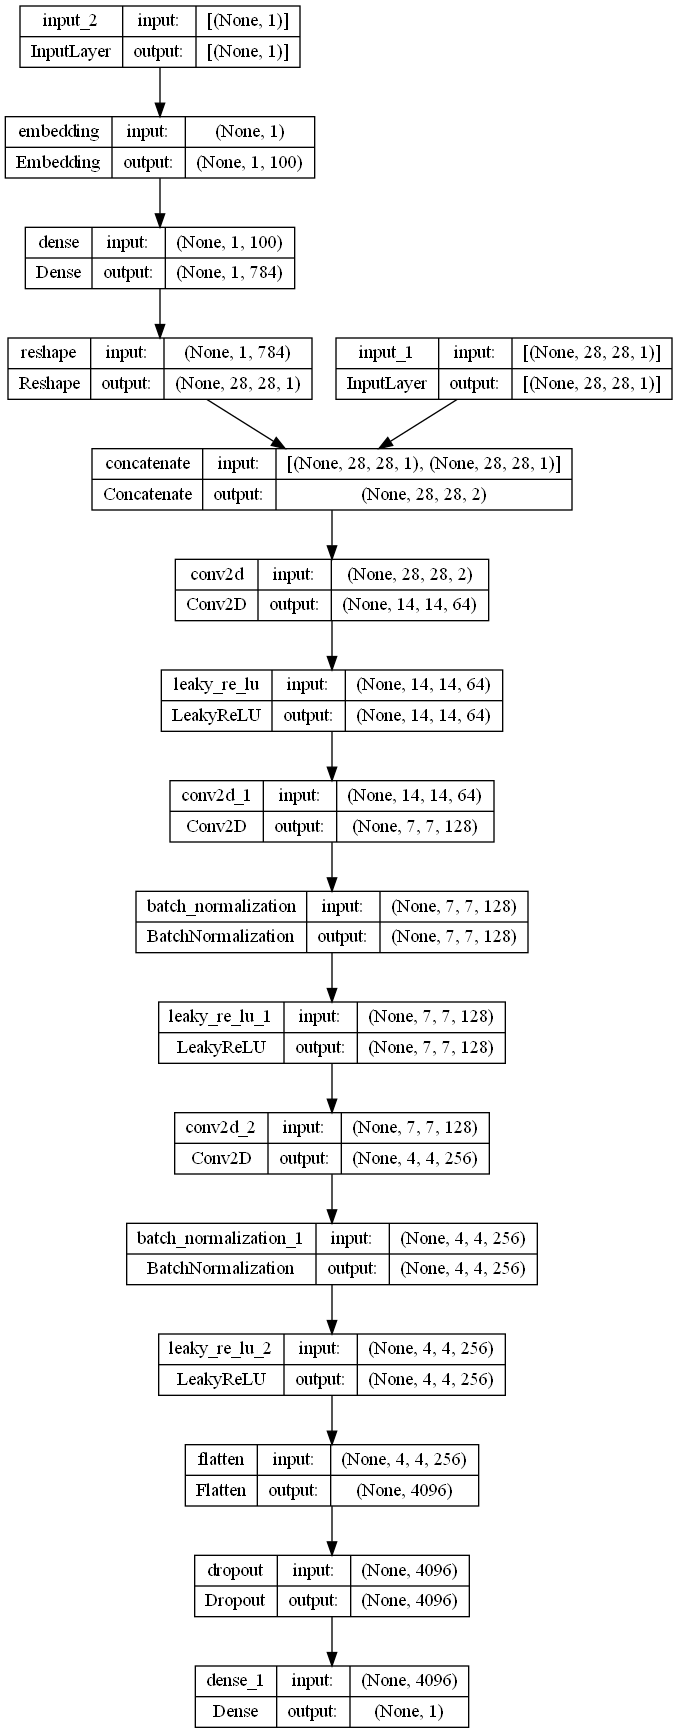

In [23]:
tf.keras.backend.clear_session()

# Build discriminator
discriminator = build_discriminator(verbose=True)

# Describe model
plot_model(discriminator, show_shapes=True, show_layer_names=True, to_file = MODEL_PATH + "discriminator.png")

# Optimizers and losses

In [12]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_function_label_smooth = tf.keras.losses.BinaryCrossentropy(
    from_logits=True, 
    label_smoothing=0.1
)

The discriminator will try to recognize ground truth data by predicting 1, and to recognize the generated images by predicting 0. Thus, we will use the binary crossentropy of the difference between the values predicted and the expected values as a measure of the loss. 

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = loss_function_label_smooth(tf.ones_like(real_output), real_output)
    # real_loss will quantify our loss to distinguish the real images
    
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    # fake_loss will quantify our loss to distinguish the fake images (generated)
    
    # Real image = 1, Fake image = 0 (array of ones and zeros)
    total_loss = real_loss + fake_loss
    return total_loss

The generator will try to fool the discriminator by making the generated images’ predictions be the closest to 1. We will then use the binary crossentropy of the difference between the discriminator’s predictions over generated data and 1 as a measure of the loss.

In [14]:
def generator_loss(fake_output):
    # We want the false images to be seen as real images (1)
    return loss_function(tf.ones_like(fake_output), fake_output)

For both the generator and the discriminator, we will use the Adam optimizer.

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)

# Training

We code the train steps manually to have complete control over the process.

In [16]:
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Training the generator
        generated_images = generator([noise, labels] , training=True) 

        # Training the discriminator
        real_output = discriminator([images, labels], training=True)           # Training the discriminator on real images
        fake_output = discriminator([generated_images, labels], training=True) # Training the discriminator on fake images

        # Calculating the losses
        gen_loss =  generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Building the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Applying the gradients (backpropagation)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [17]:
g_losses = []
d_losses = []
def train(dataset, epochs, seed, seed_labels):

    num_batches = int(TOTAL_IMAGES/BATCH_SIZE)
    for epoch in range(epochs):
        start = time.time() # Start time of the epoch
        for img_batch, lbl_batch in dataset:
            gen_loss, disc_loss = train_step(img_batch, lbl_batch)
            
            # Save the losses
            g_losses.append(np.array(gen_loss))  
            d_losses.append(np.array(disc_loss))

        # Save the images
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch + 1,seed,g_losses,d_losses,conditions=seed_labels,x_axis='total')

        # Print stats
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print("Generator loss for last batch: ",g_losses[-1])
        print("Discriminator loss for last batch: ",d_losses[-1])

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed,g_losses,d_losses,conditions=seed_labels,x_axis='total')

We will reuse this seed overtime, so it's easier to visualize progress in the animated GIF.

In [18]:
seed = tf.random.normal([NUM_EXAMPLES, LATENT_DIM])
#seed_labels = np.asarray([0,1,2,3,4,0,1,2,3,4,5,6,7,8,9,5,6,7,8,9],dtype=np.int64)
seed_labels = np.asarray([0,1,2,3,4,0,1,2,3,4,5,6,7,8,9,5,6,7,8,9]).reshape(-1,1)

This following cell launches the training.

In [ ]:
%%time
train(dataset, EPOCHS, seed, seed_labels)

# Saving and loading the models

Saving the models and the losses

In [ ]:
generator.save("." + os.sep + DATASET + os.sep + 'models' + os.sep + 'generator.h5')
discriminator.save("." + os.sep + DATASET + os.sep + 'models' + os.sep + 'discriminator.h5')

np.save("." + os.sep + DATASET + os.sep + 'losses' + os.sep + 'g_losses_cond.npy',g_losses)
np.save("." + os.sep + DATASET + os.sep + 'losses' + os.sep + 'd_losses_cond.npy',d_losses)

Loading the models

In [ ]:
generator_l = tf.keras.models.load_model("." + os.sep + DATASET + os.sep + "models" + os.sep + "generator.h5")
discriminator_l = tf.keras.models.load_model("." + os.sep + DATASET + os.sep + "models" + os.sep + "discriminator.h5")

# Visualizing the losses

In [ ]:
samples = 256
g_losses_sampled = []
d_losses_sampled = []
xs = []


for i in range(len(g_losses) // samples):
    g_losses_sampled.append(np.mean(g_losses[i*samples:(i+1)*samples]))
    d_losses_sampled.append(np.mean(d_losses[i*samples:(i+1)*samples]))
    xs.append(i*samples + samples/2)

plt.figure(figsize=(20,10))
  
plt.plot(xs, g_losses_sampled, "r-")
plt.plot(xs, d_losses_sampled, "b-")

red_patch = mpatches.Patch(color='red', label='Generator loss')
blue_patch = mpatches.Patch(color='blue', label='Discriminator loss')
plt.legend(handles=[red_patch,blue_patch])
plt.show()


# Generating a GIF of the training process

In [ ]:
anim_file = "." + os.sep + DATASET + os.sep + f'{DATASET}.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob("." + os.sep + DATASET + os.sep + 'imgs' + os.sep + 'image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 10*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# Generating samples from a specific class

In [ ]:
def show_class(model, k=None, classes=None):
    if classes:
        print("Generating {} images...".format(classes[k]))
        input = tf.random.normal([NUM_EXAMPLES, LATENT_DIM])
        labels = np.asarray([k]*NUM_EXAMPLES)
        predictions = model([input, labels], training=False)
    else:
        print("Generating images...")
        input = tf.random.normal([NUM_EXAMPLES, LATENT_DIM])
        labels=None
        predictions = model([input], training=False)
        

    fig = plt.figure(figsize=(10,10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 5, i+1)
        if classes:
            plt.title(classes[k])
        plt.imshow((predictions[i]+1) / 2)
        plt.axis('off')
    plt.show()
    
show_class(generator_l, k=0, classes=CLASSES)